In [1]:
import pandas as pd
import glob
import json 
import numpy as np
from pandarallel import pandarallel
import requests
# Initialization
pandarallel.initialize(nb_workers=4, use_memory_fs=False)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
GOOGLE_API= ""
with open("Google_api_key.txt", 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            GOOGLE_API = f.read().strip()

In [3]:
pip install pandarallel

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Get the data 
from the Logic App workflow, we get several json file, hence need to concatenate all together

In [4]:
# concatenate the json files

df = pd.read_json('./Data/WithCoordinates_Finnyeardata_WholeNorway/WithCoordinates_1987_Finnyeardata_WholeNorway_1987_label_7.json')

In [5]:
df.head()

,Location,ad_id,ad_link,ad_type,energy_label,from_year,lat,local_area_name,lon,number_of_bedrooms,owner_type_description,property_type_description,size_from,to_year,type
0,"Vanylvsvegen 1144, Fiskå",261340328,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1987,62.09800,FISKÅ,5.59500,4,Eier (Selveier),Enebolig,178,1987,realestate
1,"Marcus Thranes gate 5, Gjøvik",261324095,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1987,60.79909,None,10.68576,2,Eier (Selveier),Leilighet,88,1987,realestate
2,"Herregårdsveien 115B, Oslo",258617331,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1987,59.84323,Ljan / Nordstrand,10.77654,1,Andel,Leilighet,51,1987,realestate
3,"Furulundtoppen 21, Oslo",257295350,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1987,59.92410,Ullern/Furulundtoppen,10.64710,2,Eier (Selveier),Leilighet,136,1987,realestate
4,"Abraham Berges vei 46A, Vanse",260514516,https://www.finn.no/realestate/homes/ad.html?f...,1,7,1987,58.10040,None,6.69778,2,Eier (Selveier),Leilighet,93,1987,realestate


In [6]:
data = []

for f in glob.glob("./Data/WithCoordinates_Finnyeardata_WholeNorway/*.json"):

    with open(f,) as infile:

        data.extend(json.load(infile))


with open("merged_file.json",'w') as outfile:

    json.dump(data, outfile)



In [7]:
len(data)

6961

### Data Cleaning

In [8]:
df = pd.DataFrame(data)

In [9]:
df.head()

,Location,ad_id,ad_link,ad_type,energy_label,from_year,lat,local_area_name,lon,number_of_bedrooms,owner_type_description,property_type_description,size_from,to_year,type
0,"Olsvikåsen 132, Olsvik",261320756,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,60.38086,Bergen Vest/Olsvik,5.22157,1,Andel,Leilighet,47.0,1979,realestate
1,"Hans Haslums Vei 33, Bekkestua",261047389,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,59.91960,DESIGNBOLIG PÅ BEKKESTUA,10.57280,6,Eier (Selveier),Enebolig,359.0,1979,realestate
2,"Oskarbakken 21, Mo i Rana",260995104,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,66.29020,Åga,14.09350,5,Eier (Selveier),Enebolig,153.0,1979,realestate
3,"Sandalssvingen 7, Stavanger",260891920,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,58.95740,SANDAL,5.68380,1,Andel,Leilighet,47.0,1979,realestate
4,"Midtåstunet 8, Førde",260886553,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,61.45764,None,5.90090,3,Andel,Rekkehus,99.0,1979,realestate


In [10]:
df['property_type_description'].value_counts()

Leilighet                3301
Enebolig                 2711
Tomannsbolig              460
Rekkehus                  385
Gårdsbruk/Småbruk          66
Andre                      19
Bygård/Flermannsbolig      10
Produksjon/Industri         4
Annet fritid                3
Garasje/Parkering           2
Name: property_type_description, dtype: int64

In [11]:
df['owner_type_description'].value_counts()

Eier (Selveier)    5455
Andel              1446
Aksje                59
Obligasjon            1
Name: owner_type_description, dtype: int64

#### energy labels 
dict ={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}

<AxesSubplot:>

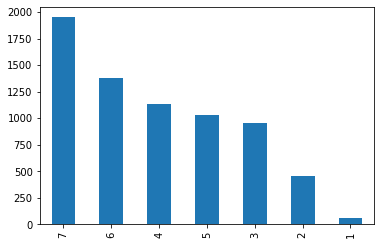

In [12]:
df['energy_label'].value_counts().plot.bar()

####  transform the year as category

# year as labels
<1901 = 0 

1901-1905=1

1906-2011=2

...

In [13]:
#Year of construction from continuous to categorical

df['byggear_cat']=pd.cut(df['from_year'],range(1901, 2027, 5),labels=range(1,26,1),right=False)
df['byggear_cat'].values.add_categories(0)
df['byggear_cat']= np.where(df['byggear_cat'].isnull(),0,df['byggear_cat'])

<AxesSubplot:>

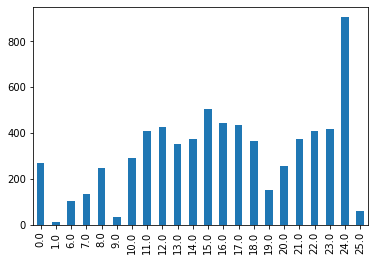

In [14]:
df['byggear_cat'].value_counts().sort_index().plot.bar()

In [15]:
    pd.pivot_table(df,values=['energy_label'], index='byggear_cat',aggfunc='value_counts',sort='energy_label')

byggear_cat  energy_label
0.0          7               229
             6                22
             5                 7
             4                 6
             2                 3
                            ... 
24.0         6                 2
25.0         4                30
             1                27
             7                 2
             6                 1
Length: 123, dtype: int64

In [16]:
corr = df.corr()

In [17]:
corr.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '14px'})

/Users/thibaud/Library/Python/3.8/lib/python/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/thibaud/Library/Python/3.8/lib/python/site-packages/pandas/io/formats/style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,ad_id,ad_type,energy_label,from_year,lat,lon,number_of_bedrooms,size_from,to_year,byggear_cat
ad_id,1.000000,nan,0.032140,-0.023219,-0.126587,-0.048328,-0.055515,-0.052239,-0.023219,-0.023882
ad_type,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
energy_label,0.032140,nan,1.000000,-0.736159,0.055159,0.064617,0.081843,0.104528,-0.736159,-0.755724
from_year,-0.023219,nan,-0.736159,1.000000,-0.008264,-0.027011,-0.054000,-0.089777,1.000000,0.992433
lat,-0.126587,nan,0.055159,-0.008264,1.000000,0.705053,0.056885,0.011109,-0.008264,-0.014979
lon,-0.048328,nan,0.064617,-0.027011,0.705053,1.000000,0.005021,-0.008220,-0.027011,-0.031668
number_of_bedrooms,-0.055515,nan,0.081843,-0.054000,0.056885,0.005021,1.000000,0.732155,-0.054000,-0.056335
size_from,-0.052239,nan,0.104528,-0.089777,0.011109,-0.008220,0.732155,1.000000,-0.089777,-0.093219
to_year,-0.023219,nan,-0.736159,1.000000,-0.008264,-0.027011,-0.054000,-0.089777,1.000000,0.992433
byggear_cat,-0.023882,nan,-0.755724,0.992433,-0.014979,-0.031668,-0.056335,-0.093219,0.992433,1.000000


#### Get the elevation

source for the script:https://developers.google.com/maps/documentation/elevation/usage-and-billing

In [18]:
df.head()

,Location,ad_id,ad_link,ad_type,energy_label,from_year,lat,local_area_name,lon,number_of_bedrooms,owner_type_description,property_type_description,size_from,to_year,type,byggear_cat
0,"Olsvikåsen 132, Olsvik",261320756,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,60.38086,Bergen Vest/Olsvik,5.22157,1,Andel,Leilighet,47.0,1979,realestate,16.0
1,"Hans Haslums Vei 33, Bekkestua",261047389,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,59.91960,DESIGNBOLIG PÅ BEKKESTUA,10.57280,6,Eier (Selveier),Enebolig,359.0,1979,realestate,16.0
2,"Oskarbakken 21, Mo i Rana",260995104,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,66.29020,Åga,14.09350,5,Eier (Selveier),Enebolig,153.0,1979,realestate,16.0
3,"Sandalssvingen 7, Stavanger",260891920,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,58.95740,SANDAL,5.68380,1,Andel,Leilighet,47.0,1979,realestate,16.0
4,"Midtåstunet 8, Førde",260886553,https://www.finn.no/realestate/homes/ad.html?f...,1,5,1979,61.45764,None,5.90090,3,Andel,Rekkehus,99.0,1979,realestate,16.0


In [19]:
def GetElevation(coordinates):
    lat, lon = coordinates.split(',')
    url = f"https://maps.googleapis.com/maps/api/elevation/json?locations={lat},{lon}&key={GOOGLE_API}"

    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    #print(response.text)
    response=response.json()
    return response['results'][0]['elevation']

In [20]:
GetElevation("59.951866,10.753608")

119.4956283569336

In [21]:
df['lat,lon'] = df['lat'].astype(str)+','+ df['lon'].astype(str)

In [ ]:
df['elevation'] = df['lat,lon'].apply(lambda x: GetElevation(x))